# 摘要

# 理论模型

玉米作为生产淀粉的主要原材料，其价格变动影响淀粉价格。若玉米价格上涨，玉米淀粉的生产成本就会提高，价格随之上升；反之价格下降。

一般来说，约 1.4 吨玉米（含 14% 水分）可以提取 1 吨玉米淀粉。

淀粉生产利润公式：淀粉生产利润 = 玉米淀粉价格 - 1.204 * 玉米价格 - 其他成本

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

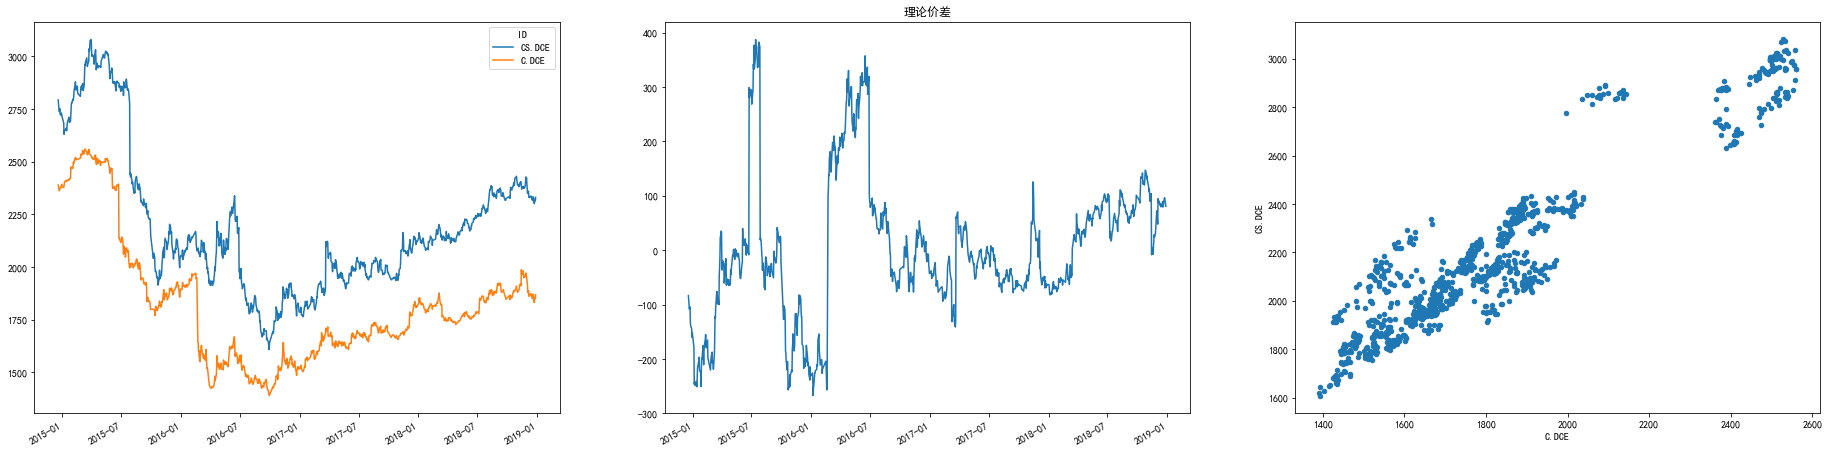

In [2]:
# 参数设置和数据准备
Exchange = "DCE"
IDs = ["CS.DCE", "C.DCE"]# 玉米淀粉，玉米主力合约
TheoryHedgeRatio = np.array([1, -1.204])
StartDT = dt.datetime(2014, 12, 19)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()

# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差")
CCPrice.plot(kind="scatter", x=CCPrice.columns[1], y=CCPrice.columns[0], ax=Axes[2]);

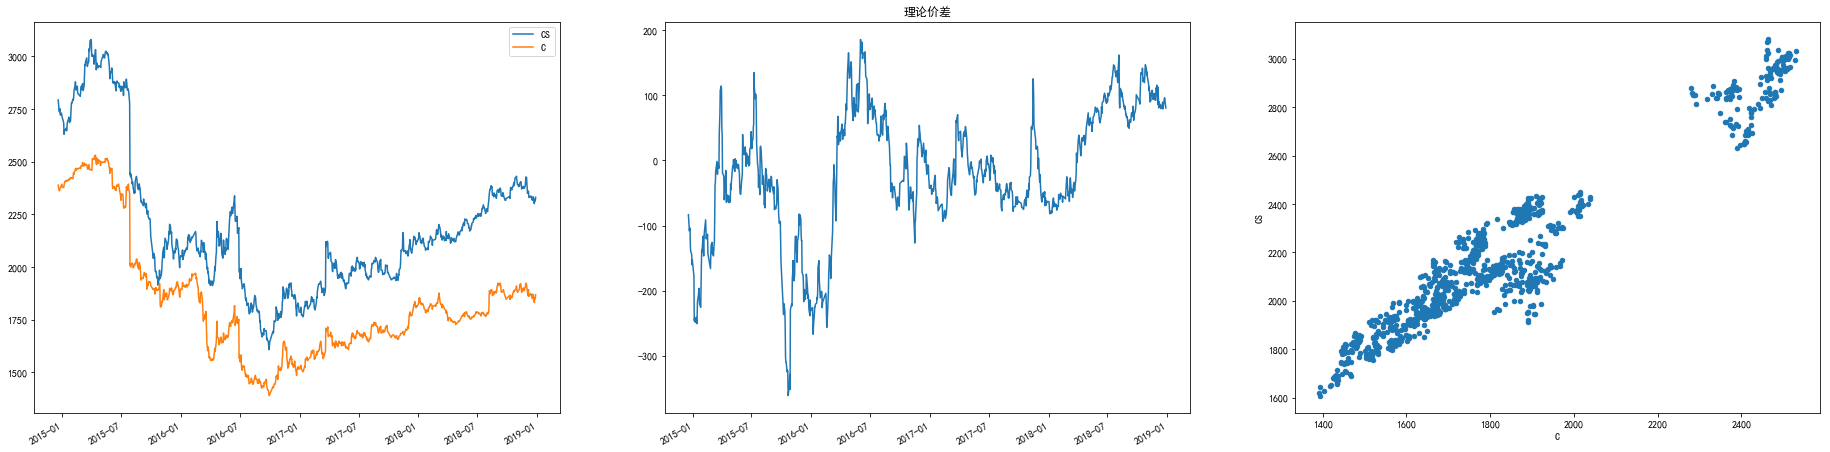

In [17]:
# 使用对齐交割月的价格数据
import re
Exchange = "DCE"
BenchmarkID = "CS.DCE"# 作为标准的主力合约
Codes = ["CS", "C"]# 合约代码
ExchangeSuffix = ["DCE", "DCE"]# 交易所后缀
StartDT = dt.datetime(2014, 12, 19)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
TheoryHedgeRatio = np.array([1, -1.204])
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[BenchmarkID], dts=DTs).iloc[0,:,:]
for i, iCode in enumerate(Codes):
    FutureIDMap[iCode] = FutureIDMap.iloc[:, 0].apply(lambda x: iCode+re.sub("\D", "", x)+"."+ExchangeSuffix[i])
FutureIDMap.pop(BenchmarkID)
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()

# 生成连续合约的价格
CCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="价格不变", rollover_ahead=True) for iID in FutureIDMap.columns}
CCPrice = pd.DataFrame(CCPrice).loc[:, FutureIDMap.columns]
# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差")
CCPrice.plot(kind="scatter", x=CCPrice.columns[1], y=CCPrice.columns[0], ax=Axes[2]);

In [5]:
# --------平稳性检验--------
# ADF 检验
for i, iID in enumerate(CCPrice.columns):
    ADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, i], regression='c', autolag="BIC")
    print(("----------- %s价格 ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]),
          ("pvalue : %f" % ADFTest[1]),
          ("usedlag : %d" % ADFTest[2]), sep="\n")
for i, iID in enumerate(CCPrice.columns):
    ADFTest = sm.tsa.stattools.adfuller(np.diff(CCPrice.values[:, i]), regression='c', autolag="BIC")
    print(("----------- Diff(%s价格, 1) ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]), 
          ("pvalue : %f" % ADFTest[1]), 
          ("usedlag : %d" % ADFTest[2]), sep="\n")

----------- CS价格 ADF Test ----------
Statistic : -1.806668
pvalue : 0.377156
usedlag : 0
----------- C价格 ADF Test ----------
Statistic : -1.782166
pvalue : 0.389351
usedlag : 0
----------- Diff(CS价格, 1) ADF Test ----------
Statistic : -30.225490
pvalue : 0.000000
usedlag : 0
----------- Diff(C价格, 1) ADF Test ----------
Statistic : -31.084571
pvalue : 0.000000
usedlag : 0


----------- CS-C Cointegration ADF Test -----------
Statistic: -2.597862
pvalue : 0.237693
----------- CS-C Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 11.665632
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 8.323759
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- CS-C Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 3.341873
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 3.341873
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.         -1.19100066]


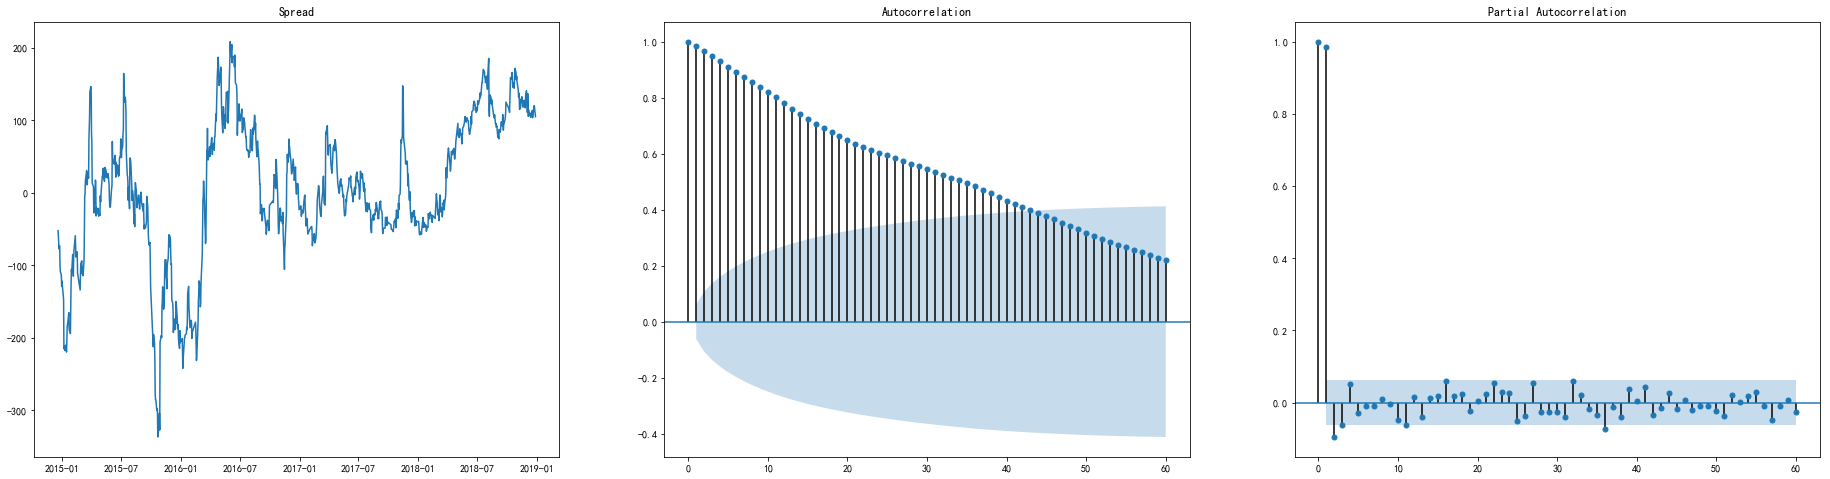

In [18]:
# --------协整检验--------
Mask = (pd.notnull(CCPrice.values[:, 0]) & pd.notnull(CCPrice.values[:, 1]))
CointADFTest = sm.tsa.stattools.coint(CCPrice.values[:, 0][Mask], CCPrice.values[:, 1][Mask], trend="c", autolag="BIC")
print(("----------- %s Cointegration ADF Test -----------" % ("-".join(CCPrice.columns), )),
      ("Statistic: %f" % CointADFTest[0]), 
      ("pvalue : %f" % CointADFTest[1]), sep="\n")

CointJohansenTest = sm.tsa.var.vecm.coint_johansen(CCPrice.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- %s Cointegration Johansen Test: r<=%d -----------" % ("-".join(CCPrice.columns), i)),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

Spread = (CCPrice * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

HalfLife: 48.842053


,0
起始时点,2014-12-19 00:00:00
结束时点,2018-12-28 00:00:00
时点数,984
总收益率,-0.121744
年化收益率,-0.0317194
年化波动率,0.0481296
Sharpe比率,-0.659043
胜率,0.60061
最大回撤率,0.177862
最大回撤开始时点,2014-12-19 00:00:00


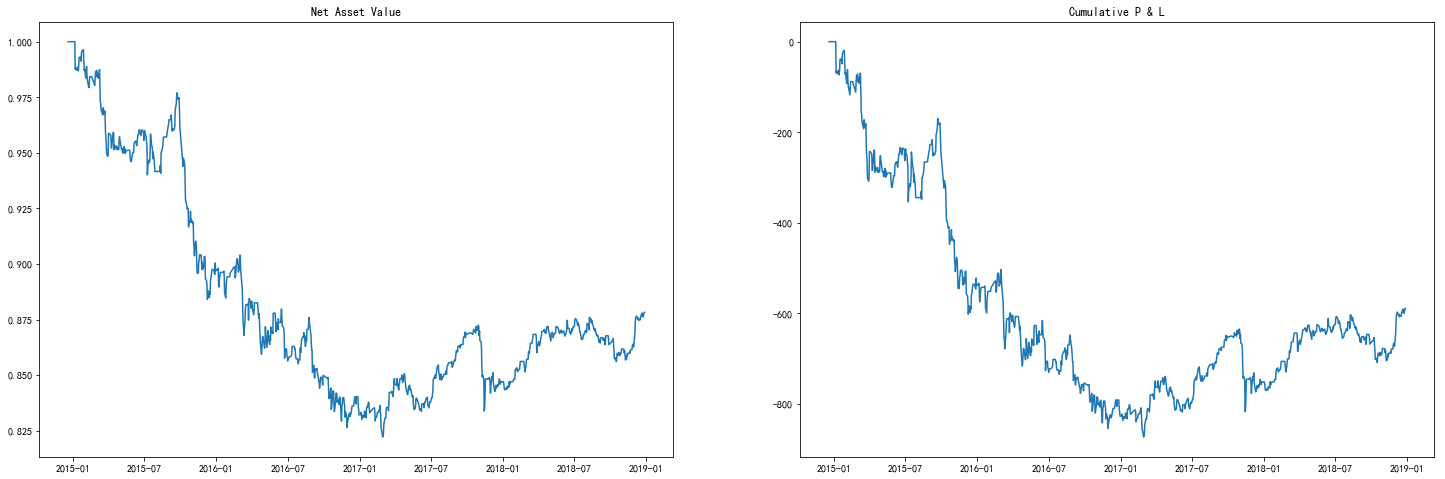

In [29]:
# --------Spread 策略--------
EntryThreshold, ExitThreshold = 1, 0
NumRatio = TheoryHedgeRatio
# NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)
LookBack = 10
# LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");